In [22]:
import spacy
import pandas as pd
import numpy as np
from glob import glob
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import randint
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

In [4]:
class textPieces(): 
    def __init__(self, author, sample=True, pieces=2): 
        self.author = author
        self.filenames = glob('data/%s*' % author)
        print('Using filenames: ', self.filenames)
        self.texts = [open(filename).read() 
                 for filename in self.filenames]
        self.lengths = [len(text) for text in self.texts]
        self.lowestLength = min(self.lengths)
        if sample: 
            self.samples = [self.sample(text) for text in self.texts]
        else: 
            self.samples = self.texts
        if pieces > 1: 
            self.labels = []
            self.pieces = []
            self.makePieces(self.filenames, self.samples, 2)
        else: 
            self.labels = [filename[6+len(self.author):-4] for filename in self.filenames]
            self.pieces = self.texts
        
    def sample(self, text): 
        """ Randomly samples from texts that are long, 
        so that we're comparing the same amount of text across documents."""
        chunkSize = self.lowestLength
        # We want a chunk of [a:b] where the max value of b is end-chunkSize
        textLength = len(text)
        maxEnd = textLength - chunkSize
        if maxEnd <= 0: 
            print('Something went wrong. maxEnd is negative or zero.')
            return text
        start = randint(0, maxEnd)
        return text[start:start+chunkSize]
    
    def makePieces(self, filenames, samples, n): 
        pieceSize = self.lowestLength / n
        for filename, sample in zip(filenames, samples): 
            for i in range(n):
                label = filename[6+len(self.author):-4] # Cut off 'data/cather-' for example and .txt
                pieceLabel = "%s-%s" % (label, i)
                start = int(i*pieceSize)
                end = int(start+pieceSize)
#                 print('Piece start: %s, piece end: %s' % (start, end))
                piece = sample[start:end]
                self.labels.append(pieceLabel)
                self.pieces.append(piece)

In [28]:
class authorAnalysis(): 
    def __init__(self, labels, docs): 
        self.labels = labels
        self.docs = docs
        self.features, self.matrix = self.vectorize()
        # Assume the date is the first four characters of the label. 
        self.pieceDates = [int(label[:4]) for label in self.labels]
        # Try to assign "early," "middle," and "late" categories (0, 1, 2) based on years. 
        self.categories = [round(cat) for cat in self.rescale(self.pieceDates, 0, 2)]
        
    #@property
    #def categories(): 
    #    pass
        
    def vectorize(self): 
        tfidf = TfidfVectorizer()
        matrix = tfidf.fit_transform(self.docs).todense()
        features = tfidf.get_feature_names()
        return features, matrix
    
    def vectorDF(self):
        """ Just a helper to visualize the TFIDF table."""
        return pd.DataFrame(self.matrix, columns=self.features, index=self.labels)
    
    def doPCA(self): 
        pca = PCA(n_components=5)
        return pca.fit_transform(self.matrix)
    
    def doTSNE(self): 
        tSNE = TSNE(n_components=2)
        return tSNE.fit_transform(self.matrix)
        
    def plotPCA(self, tSNE=False, labels=True, saveTo=False, clustering='bgm'): 
        if tSNE: 
            pcaTable = self.doTSNE()
        else: 
            pcaTable = self.doPCA()
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        if clustering == 'kmeans': 
            colors = self.kmeans()
        if clustering == 'bgm': 
            colors = self.bgm()
        ax = plt.scatter(df[0], df[1], s=self.size, c=colors)
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False)
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    def kmeans(self): 
        pcaOut = self.doPCA()
        kmeans = KMeans(n_clusters=3)
        return kmeans.fit_predict(pcaOut)
    
    def bgm(self): 
        pcaOut = self.doPCA()
        bgm = BayesianGaussianMixture(n_components=3).fit(pcaOut)
        return bgm.predict(pcaOut)
        
    def metrics(self): 
        randK = adjusted_rand_score(self.categories, self.kmeans())
        randB = adjusted_rand_score(self.categories, self.bgm())
        print('Adjusted rand score, Kmeans: ', randK)
        print('Adjusted rand score, BGM: ', randB)
        randK = adjusted_mutual_info_score(self.categories, self.kmeans())
        randB = adjusted_mutual_info_score(self.categories, self.bgm())
        print('Adjusted mutual info score, Kmeans: ', randK)
        print('Adjusted mutual info score, BGM: ', randB)

# Proust

Using filenames:  ['data/proust-1920-guermantes.txt', 'data/proust-1919-lombre.txt', 'data/proust-1927-retrouve.txt', 'data/proust-1923-prisonniere.txt', 'data/proust-1921-sodome.txt', 'data/proust-1925-albertine.txt', 'data/proust-1913-swann.txt']
Something went wrong. maxEnd is negative or zero.
Adjusted rand score, Kmeans:  0.102728731942
Adjusted rand score, BGM:  0.0278260869565
Adjusted mutual info score, Kmeans:  0.0229992765103
Adjusted mutual info score, BGM:  0.0297291453426


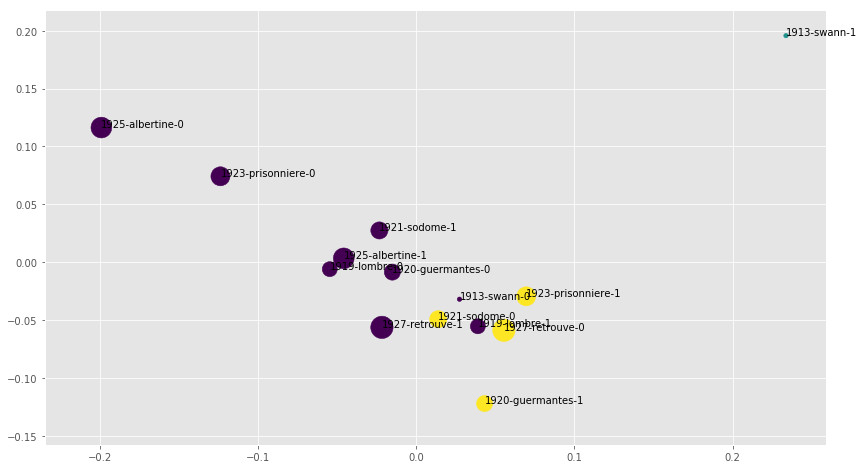

In [31]:
pieces = textPieces('proust', pieces=3)
analysis = authorAnalysis(pieces.labels, pieces.pieces)
analysis.plotPCA()
analysis.metrics()

In [32]:
analysis.doTSNE()

array([[  2.38362148e-05,   2.65082516e-05],
       [  2.18225441e-05,  -8.20808596e-05],
       [ -2.15723376e-04,   1.64419282e-04],
       [ -6.65790414e-05,  -4.11623989e-05],
       [  7.93201755e-05,  -3.86810438e-06],
       [  1.37075018e-04,   7.06348908e-05],
       [ -1.51502069e-05,   8.36760829e-05],
       [ -1.43077122e-04,   1.20550133e-04],
       [  1.54955049e-04,  -3.88092789e-05],
       [ -7.62046581e-05,  -8.99504930e-05],
       [ -7.39815991e-05,   1.27022866e-05],
       [  4.41299374e-05,  -1.76896865e-05],
       [ -8.21325833e-05,  -1.13441839e-04],
       [ -9.45541063e-07,   5.23590269e-05]])

In [33]:
analysis.categories, analysis.kmeans(), analysis.bgm()

([1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 0, 0],
 array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0], dtype=int32),
 array([0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1]))

Using filenames:  ['data/dickens-1839-oliver-twist.txt', 'data/dickens-1865-our-mutual-friend.txt', 'data/dickens-1859-a-tale-of-two-cities.txt', 'data/dickens-1850-david-copperfield.txt', 'data/dickens-1861-great-expectations.txt', 'data/dickens-1870-the-mystery-of-edwin-drood.txt', 'data/dickens-1848-dombey-and-son.txt', 'data/dickens-1841-the-old-curiosity-shop.txt', 'data/dickens-1854-hard-times.txt', 'data/dickens-1844-martin-chuzzlewit.txt', 'data/dickens-1857-little-dorrit.txt', 'data/dickens-1841-barnaby-rudge.txt', 'data/dickens-1837-the-pickwick-papers.txt', 'data/dickens-1839-nicholas-nickleby.txt', 'data/dickens-1853-bleak-house.txt']
Something went wrong. maxEnd is negative or zero.
Adjusted rand score, Kmeans:  0.329679038436
Adjusted rand score, BGM:  0.0364905957878
Adjusted mutual info score, Kmeans:  0.303569997753
Adjusted mutual info score, BGM:  0.0100905781295


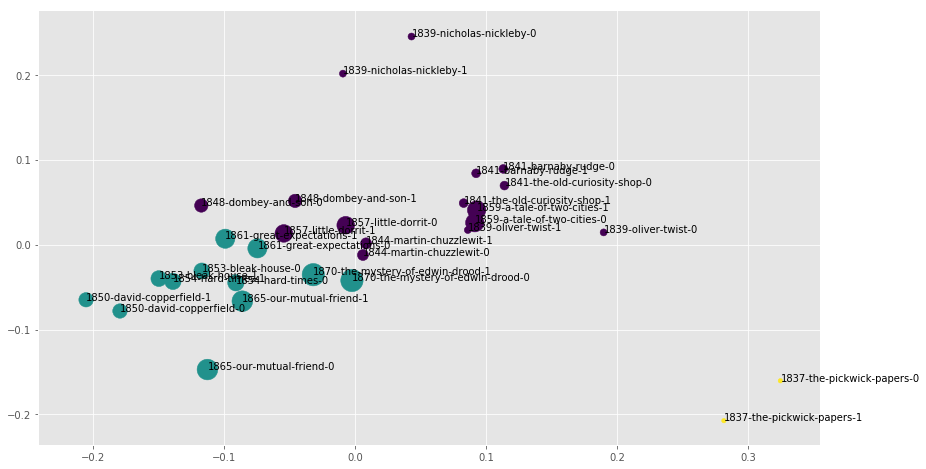

In [34]:
pieces = textPieces('dickens')
analysis = authorAnalysis(pieces.labels, pieces.pieces)
analysis.plotPCA()
analysis.metrics()

# Conrad

Using filenames:  ['data/conrad-1897-the-nigger-of-the-narcissus.txt', 'data/conrad-1907-the-secret-agent.txt', 'data/conrad-1911-under-western-eyes.txt', 'data/conrad-1895-almayers-folly.txt', 'data/conrad-1900-lord-jim.txt', 'data/conrad-1902-typhoon.txt', 'data/conrad-1920-the-rescue.txt', 'data/conrad-1919-the-arrow-of-gold.txt', 'data/conrad-1925-suspense.txt', 'data/conrad-1896-an-outcast-of-the-islands.txt', 'data/conrad-1899-heart-of-darkness.txt', 'data/conrad-1913-chance.txt', 'data/conrad-1923-the-rover.txt', 'data/conrad-1902-the-end-of-the-tether.txt', 'data/conrad-1917-the-shadow-line.txt', 'data/conrad-1904-nostromo.txt', 'data/conrad-1915-victory.txt']
Something went wrong. maxEnd is negative or zero.


,0,1,2,3,4,distance
1907-the-secret-agent-0,0.177296,0.464728,0.014885,0.002609,0.028648,0.497400
1907-the-secret-agent-1,0.195930,0.429935,-0.019698,0.002456,-0.000507,0.472475
1920-the-rescue-0,0.329039,-0.134073,0.285736,-0.120591,-0.072935,0.355306
1920-the-rescue-1,0.208015,-0.105817,0.204015,-0.096756,-0.046633,0.233383
1895-almayers-folly-0,-0.193119,0.057337,0.159815,-0.022028,0.152368,0.201451
1897-the-nigger-of-the-narcissus-0,-0.174414,0.034713,0.039144,-0.027388,-0.001380,0.177834
1897-the-nigger-of-the-narcissus-1,-0.174158,0.023071,0.058557,-0.018275,-0.001412,0.175680
1902-typhoon-0,-0.166300,0.036889,0.007913,-0.020691,-0.044183,0.170343
1902-typhoon-1,-0.164938,0.034804,0.024497,-0.008375,-0.044109,0.168570
1919-the-arrow-of-gold-1,0.125976,-0.083886,-0.087077,-0.061589,-0.000230,0.151350


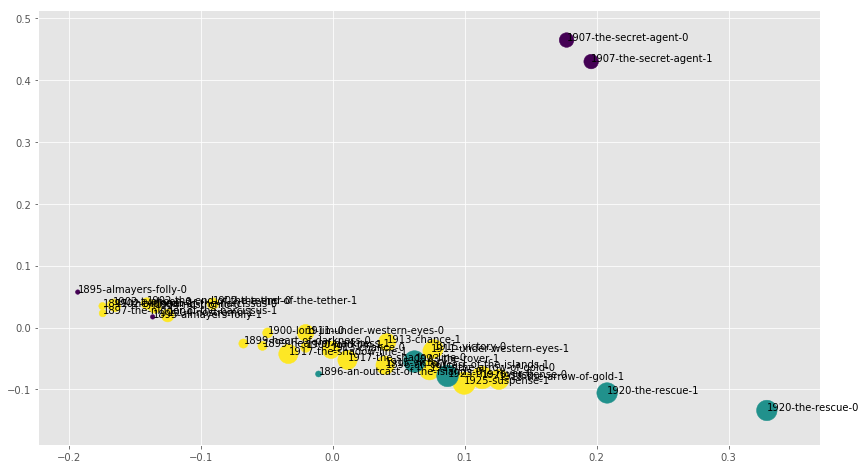

In [35]:
pieces = textPieces('conrad')
analysis = authorAnalysis(pieces.labels, pieces.pieces)
analysis.plotPCA()

# Jean Genet

Using filenames:  ['data/genet-1986-captif-amoreux.txt', 'data/genet-1947-pompes-funèbres.txt', 'data/genet-1949-journal-du-voleur.txt', 'data/genet-1947-querelle-de-brest.txt', 'data/genet-1946-miracle-de-la-rose.txt', 'data/genet-1942-notre-dame.txt']
Something went wrong. maxEnd is negative or zero.
Adjusted rand score, Kmeans:  -0.0714285714286
Adjusted rand score, BGM:  -0.0714285714286
Adjusted mutual info score, Kmeans:  0.026412062189
Adjusted mutual info score, BGM:  0.026412062189


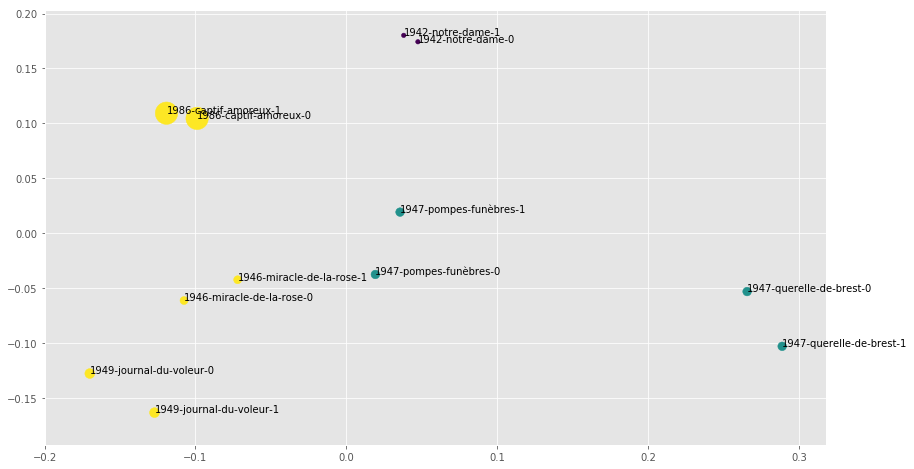

In [36]:
pieces = textPieces('genet')
analysis = authorAnalysis(pieces.labels, pieces.pieces)
analysis.plotPCA()
analysis.metrics()

In [37]:
analysis.labels, analysis.categories, analysis.bgm()

(['1986-captif-amoreux-0',
  '1986-captif-amoreux-1',
  '1947-pompes-funèbres-0',
  '1947-pompes-funèbres-1',
  '1949-journal-du-voleur-0',
  '1949-journal-du-voleur-1',
  '1947-querelle-de-brest-0',
  '1947-querelle-de-brest-1',
  '1946-miracle-de-la-rose-0',
  '1946-miracle-de-la-rose-1',
  '1942-notre-dame-0',
  '1942-notre-dame-1'],
 [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 array([0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 1, 1]))

# Hemingway

Using filenames:  ['data/hemingway-1926-torrents-spring.txt', 'data/hemingway-1986-garden-of-eden.txt', 'data/hemingway-1937-to-have-and-have.txt', 'data/hemingway-1926-sun-also-rises.txt', 'data/hemingway-1940-for-whom-the-bell.txt', 'data/hemingway-1952-old-man-and-the-sea.txt', 'data/hemingway-1936-short-happy.txt', 'data/hemingway-1929-farewell-to-arms.txt', 'data/hemingway-1950-across-the-river.txt', 'data/hemingway-1970-islands-in-the-stream.txt']
Something went wrong. maxEnd is negative or zero.
Adjusted rand score, Kmeans:  -0.085466179159
Adjusted rand score, BGM:  -0.085466179159
Adjusted mutual info score, Kmeans:  -0.0022553468851
Adjusted mutual info score, BGM:  0.00714737777444


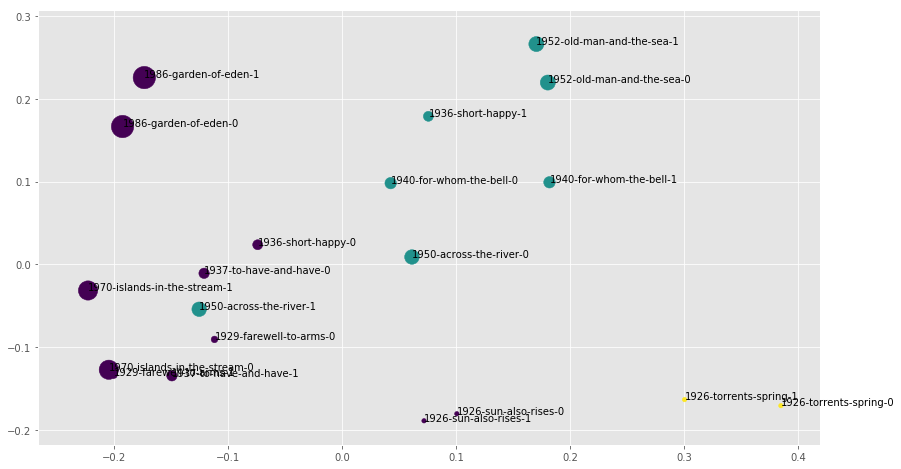

In [38]:
pieces = textPieces('hemingway')
analysis = authorAnalysis(pieces.labels, pieces.pieces)
analysis.plotPCA()
analysis.metrics()

In [39]:
analysis.labels, analysis.categories, analysis.bgm()

(['1926-torrents-spring-0',
  '1926-torrents-spring-1',
  '1986-garden-of-eden-0',
  '1986-garden-of-eden-1',
  '1937-to-have-and-have-0',
  '1937-to-have-and-have-1',
  '1926-sun-also-rises-0',
  '1926-sun-also-rises-1',
  '1940-for-whom-the-bell-0',
  '1940-for-whom-the-bell-1',
  '1952-old-man-and-the-sea-0',
  '1952-old-man-and-the-sea-1',
  '1936-short-happy-0',
  '1936-short-happy-1',
  '1929-farewell-to-arms-0',
  '1929-farewell-to-arms-1',
  '1950-across-the-river-0',
  '1950-across-the-river-1',
  '1970-islands-in-the-stream-0',
  '1970-islands-in-the-stream-1'],
 [0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
 array([1, 1, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]))